In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option("display.max_columns", 100)


import pandas as pd
import requests
from xml.etree import ElementTree
import numpy as np
import folium

import statsmodels.api as sm
from statsmodels.formula.api import ols
import statsmodels.formula as smf

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import statsmodels
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from matplotlib.ticker import FuncFormatter

In [3]:
df = pd.read_csv('data/kc_house_data.csv')
ogdf = pd.read_csv('data/kc_house_data.csv')

# Column Names and descriptions for Kings County Data Set
* **id** - unique identified for a house
* **dateDate** - house was sold
* **pricePrice** -  is prediction target
* **bedroomsNumber** -  of Bedrooms/House
* **bathroomsNumber** -  of bathrooms/bedrooms
* **sqft_livingsquare** -  footage of the home
* **sqft_lotsquare** -  footage of the lot
* **floorsTotal** -  floors (levels) in house
* **waterfront** - House which has a view to a waterfront
* **view** - Has been viewed
* **condition** - How good the condition is ( Overall )
* **grade** - overall grade given to the housing unit, based on King County grading system
* **sqft_above** - square footage of house apart from basement
* **sqft_basement** - square footage of the basement
* **yr_built** - Built Year
* **yr_renovated** - Year when house was renovated
* **zipcode** - zip
* **lat** - Latitude coordinate
* **long** - Longitude coordinate
* **sqft_living15** - The square footage of interior housing living space for the nearest 15 neighbors
* **sqft_lot15** - The square footage of the land lots of the nearest 15 neighbors

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  float64
 9   view           21534 non-null  float64
 10  condition      21597 non-null  int64  
 11  grade          21597 non-null  int64  
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

In [5]:
df.isna().sum()

id                  0
date                0
price               0
bedrooms            0
bathrooms           0
sqft_living         0
sqft_lot            0
floors              0
waterfront       2376
view               63
condition           0
grade               0
sqft_above          0
sqft_basement       0
yr_built            0
yr_renovated     3842
zipcode             0
lat                 0
long                0
sqft_living15       0
sqft_lot15          0
dtype: int64

Getting rid of correlated independent variables

In [6]:
test = df.corr().abs().stack().reset_index().sort_values(0,ascending=False)
test['pairs'] = list(zip(test.level_0,test.level_1))
test.set_index(['pairs'], inplace=True)
test.drop(columns=['level_1','level_0'], inplace=True)
test.columns = ['cc']
test.drop_duplicates(inplace=True)

In [7]:
test.sort_values('cc',ascending=False, inplace=True)
test[test.cc >.75]

,cc
pairs,
"(id, id)",1.000000
"(sqft_living, sqft_above)",0.876448
"(grade, sqft_living)",0.762779
"(sqft_living, sqft_living15)",0.756402
"(sqft_above, grade)",0.756073
"(sqft_living, bathrooms)",0.755758


In [8]:
#dropping sqft above due to correlation with sqft living
df.drop(columns=["sqft_above"], inplace= True)
ogdf.drop(columns=["sqft_above"], inplace= True)

In [9]:
df.reset_index(inplace=True)

In [10]:
df.drop('index',axis=1,inplace=True)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  float64
 9   view           21534 non-null  float64
 10  condition      21597 non-null  int64  
 11  grade          21597 non-null  int64  
 12  sqft_basement  21597 non-null  object 
 13  yr_built       21597 non-null  int64  
 14  yr_renovated   17755 non-null  float64
 15  zipcode        21597 non-null  int64  
 16  lat            21597 non-null  float64
 17  long           21597 non-null  float64
 18  sqft_l

In [12]:
df.sqft_basement.value_counts()

0.0       12826
?           454
600.0       217
500.0       209
700.0       208
          ...  
2490.0        1
1920.0        1
784.0         1
176.0         1
1548.0        1
Name: sqft_basement, Length: 304, dtype: int64

In [13]:
#replacing ? with 0
df['sqft_basement'] = df.sqft_basement.replace(to_replace= '?', value = '0')
ogdf['sqft_basement'] = ogdf.sqft_basement.replace(to_replace= '?', value = '0')

In [14]:
df.sqft_basement = df.sqft_basement.map(lambda x: int(x.replace('.0','')) if type(x) != 'int' else x)
ogdf.sqft_basement = ogdf.sqft_basement.map(lambda x: int(x.replace('.0','')) if type(x) != 'int' else x)

In [15]:
#making date datetime format
df['date'] = pd.to_datetime(df['date'])

In [31]:
df['age'] = 2020 - df['yr_built']

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   id             21597 non-null  int64         
 1   date           21597 non-null  datetime64[ns]
 2   price          21597 non-null  float64       
 3   bedrooms       21597 non-null  int64         
 4   bathrooms      21597 non-null  float64       
 5   sqft_living    21597 non-null  int64         
 6   sqft_lot       21597 non-null  int64         
 7   floors         21597 non-null  float64       
 8   waterfront     19221 non-null  float64       
 9   view           21534 non-null  float64       
 10  condition      21597 non-null  int64         
 11  grade          21597 non-null  int64         
 12  sqft_basement  21597 non-null  int64         
 13  yr_built       21597 non-null  int64         
 14  yr_renovated   17755 non-null  float64       
 15  zipcode        2159

In [17]:
#adding column for month
df['month'] = df.date.dt.month

In [18]:
conts = []
cats = []

In [19]:

for col in df.columns:
    if(df[col].nunique() < 25):
        cats.append(col)
    else:
        conts.append(col)

In [20]:
conts.remove('zipcode')

In [21]:
conts

['id',
 'date',
 'price',
 'bathrooms',
 'sqft_living',
 'sqft_lot',
 'sqft_basement',
 'yr_built',
 'yr_renovated',
 'lat',
 'long',
 'sqft_living15',
 'sqft_lot15']

In [22]:
cats.append('zipcode')

In [23]:
cats

['bedrooms',
 'floors',
 'waterfront',
 'view',
 'condition',
 'grade',
 'month',
 'zipcode']

In [24]:
dfconts = df[conts]
dfconts

,id,date,price,bathrooms,sqft_living,sqft_lot,sqft_basement,yr_built,yr_renovated,lat,long,sqft_living15,sqft_lot15
0,7129300520,2014-10-13,221900.0,1.00,1180,5650,0,1955,0.0,47.5112,-122.257,1340,5650
1,6414100192,2014-12-09,538000.0,2.25,2570,7242,400,1951,1991.0,47.7210,-122.319,1690,7639
2,5631500400,2015-02-25,180000.0,1.00,770,10000,0,1933,NaN,47.7379,-122.233,2720,8062
3,2487200875,2014-12-09,604000.0,3.00,1960,5000,910,1965,0.0,47.5208,-122.393,1360,5000
4,1954400510,2015-02-18,510000.0,2.00,1680,8080,0,1987,0.0,47.6168,-122.045,1800,7503
...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,263000018,2014-05-21,360000.0,2.50,1530,1131,0,2009,0.0,47.6993,-122.346,1530,1509
21593,6600060120,2015-02-23,400000.0,2.50,2310,5813,0,2014,0.0,47.5107,-122.362,1830,7200
21594,1523300141,2014-06-23,402101.0,0.75,1020,1350,0,2009,0.0,47.5944,-122.299,1020,2007
21595,291310100,2015-01-16,400000.0,2.50,1600,2388,0,2004,0.0,47.5345,-122.069,1410,1287


In [25]:
dfcats = df[cats]

array([[<AxesSubplot:title={'center':'bedrooms'}>,
        <AxesSubplot:title={'center':'floors'}>,
        <AxesSubplot:title={'center':'waterfront'}>],
       [<AxesSubplot:title={'center':'view'}>,
        <AxesSubplot:title={'center':'condition'}>,
        <AxesSubplot:title={'center':'grade'}>],
       [<AxesSubplot:title={'center':'month'}>,
        <AxesSubplot:title={'center':'zipcode'}>, <AxesSubplot:>]],
      dtype=object)

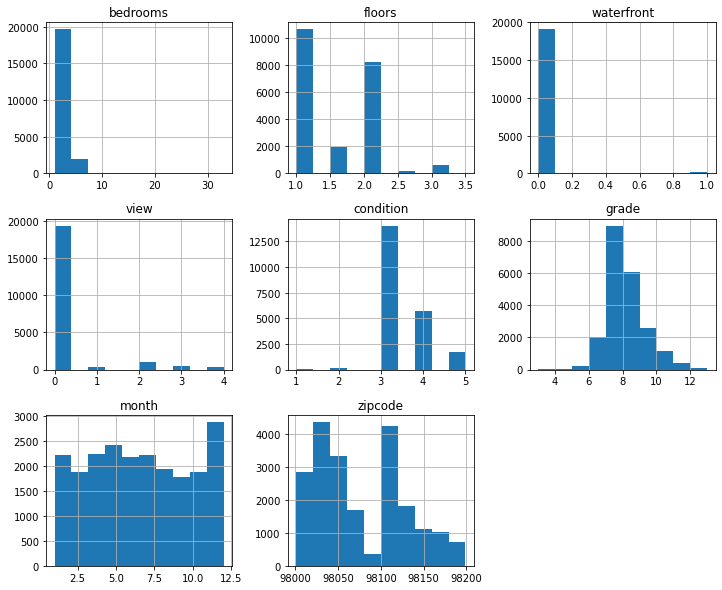

In [26]:
dfcats.hist(figsize=(12,10))

array([[<AxesSubplot:title={'center':'id'}>,
        <AxesSubplot:title={'center':'price'}>,
        <AxesSubplot:title={'center':'bathrooms'}>],
       [<AxesSubplot:title={'center':'sqft_living'}>,
        <AxesSubplot:title={'center':'sqft_lot'}>,
        <AxesSubplot:title={'center':'sqft_basement'}>],
       [<AxesSubplot:title={'center':'yr_built'}>,
        <AxesSubplot:title={'center':'yr_renovated'}>,
        <AxesSubplot:title={'center':'lat'}>],
       [<AxesSubplot:title={'center':'long'}>,
        <AxesSubplot:title={'center':'sqft_living15'}>,
        <AxesSubplot:title={'center':'sqft_lot15'}>]], dtype=object)

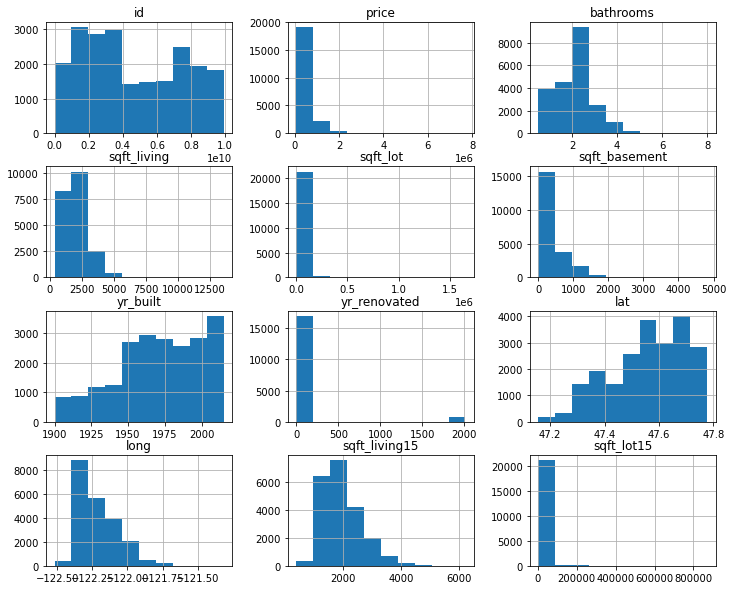

In [27]:
dfconts.hist(figsize=(12,10))

<AxesSubplot:xlabel='sqft_living', ylabel='price'>

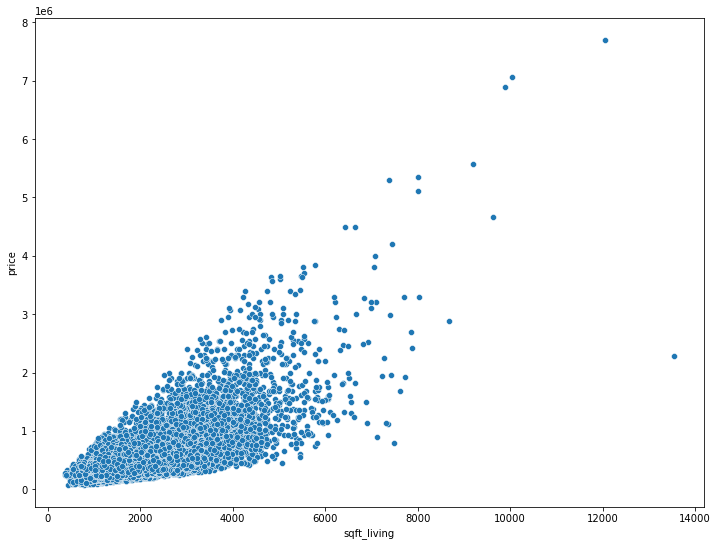

In [48]:
plt.figure(figsize=(12,9))
sns.scatterplot(x='sqft_living', y='price',data=df,ci='sd')

<AxesSubplot:xlabel='bedrooms', ylabel='Count'>

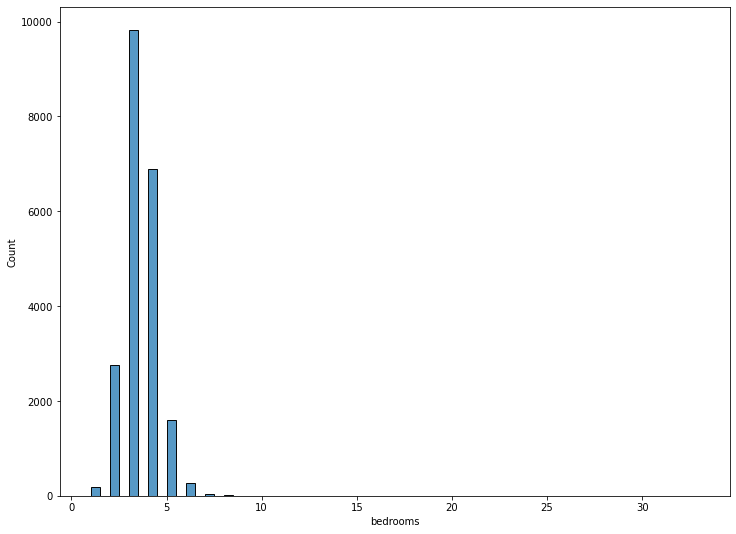

In [38]:
plt.figure(figsize=(12,9))
sns.histplot(x='bedrooms',data=df, binwidth=.5)

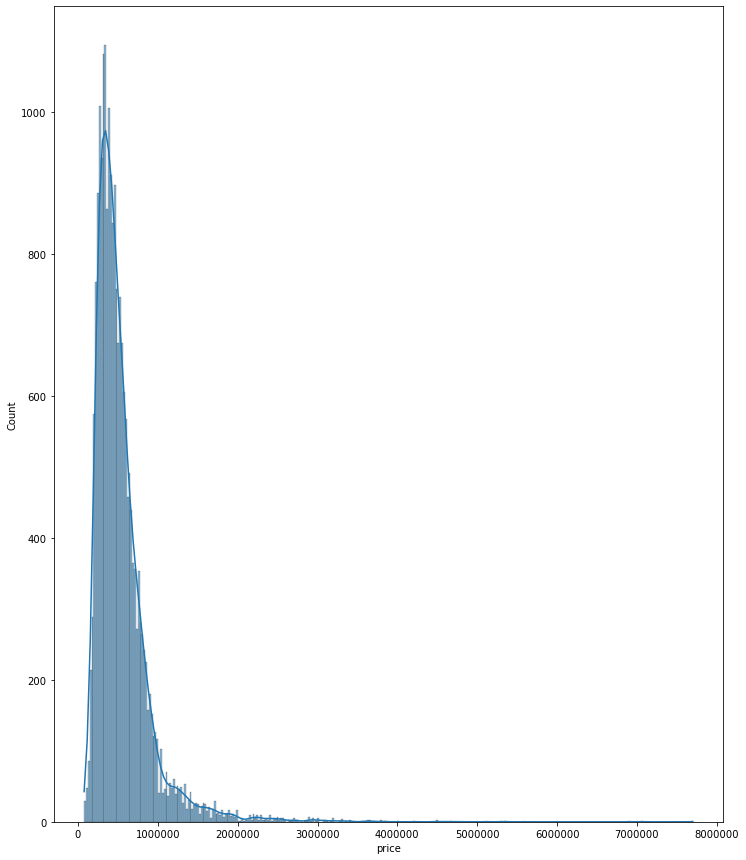

In [28]:
#looks like 90-99% of homes have 10 or less bedrooms
plt.figure(figsize=(12,15))
sns.histplot(x='price',data=df,bins='auto',kde=True,)
plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda x, _: int(x)))


<AxesSubplot:xlabel='age', ylabel='price'>

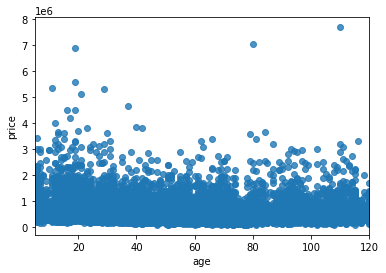

In [32]:
sns.regplot(x='age',y='price', data=df)

In [33]:
df[df.waterfront ==1]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,month,age
49,822039084,2015-03-11,1350000.0,3,2.50,2753,65005,1.0,1.0,2.0,5,9,588,1953,0.0,98070,47.4041,-122.451,2680,72513,3,67
230,8096000060,2015-04-13,655000.0,2,1.75,1450,15798,2.0,1.0,4.0,3,7,220,1915,1978.0,98166,47.4497,-122.375,2030,13193,4,105
246,2025069065,2014-09-29,2400000.0,4,2.50,3650,8354,1.0,1.0,4.0,3,9,1820,2000,0.0,98074,47.6338,-122.072,3120,18841,9,20
264,2123039032,2014-10-27,369900.0,1,0.75,760,10079,1.0,1.0,4.0,5,5,0,1936,0.0,98070,47.4683,-122.438,1230,14267,10,84
300,3225069065,2014-06-24,3080000.0,4,5.00,4550,18641,1.0,1.0,4.0,3,10,1950,2002,0.0,98074,47.6053,-122.077,4550,19508,6,18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19968,2025069140,2015-03-17,1900000.0,3,2.50,2830,4334,3.0,1.0,4.0,3,10,0,2006,0.0,98074,47.6318,-122.071,2830,38211,3,14
20309,518500480,2014-08-11,3000000.0,3,3.50,4410,10756,2.0,1.0,4.0,3,11,980,2014,0.0,98056,47.5283,-122.205,3550,5634,8,6
20751,8043700105,2015-04-17,2300000.0,4,4.00,4360,8175,2.5,1.0,4.0,3,10,420,2007,0.0,98008,47.5724,-122.104,2670,8525,4,13
21185,518500460,2014-10-08,2230000.0,3,3.50,3760,5634,2.0,1.0,4.0,3,11,930,2014,0.0,98056,47.5285,-122.205,3560,5762,10,6


In [83]:
df[df.waterfront == 1].describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,month,been_renovated,age
count,2.498000e+03,2.498000e+03,2498.000000,2498.000000,2498.000000,2.498000e+03,2498.000000,2498.0,2498.000000,2498.000000,2498.000000,2498.000000,2498.000000,2050.000000,2498.000000,2498.000000,2498.000000,2498.000000,2498.000000,2498.000000,2498.000000,2498.000000
mean,4.485358e+09,5.958819e+05,3.358687,2.138010,2127.872298,1.597082e+04,1.493395,1.0,0.460769,3.414331,7.698159,316.503203,1970.200961,115.752683,98080.608086,47.560295,-122.216966,2017.672538,12998.034027,6.534828,0.053243,49.799039
std,2.872122e+09,4.931427e+05,0.919381,0.799068,976.539577,4.614426e+04,0.537776,0.0,1.129333,0.659537,1.222275,477.419727,29.195508,466.408247,54.460316,0.136351,0.140787,711.262217,24833.152300,3.112847,0.224562,29.195508
min,1.000102e+06,8.000000e+04,1.000000,0.750000,430.000000,6.000000e+02,1.000000,1.0,0.000000,1.000000,4.000000,0.000000,1900.000000,0.000000,98001.000000,47.180800,-122.514000,750.000000,788.000000,1.000000,0.000000,5.000000
25%,2.065726e+09,3.270000e+05,3.000000,1.562500,1440.000000,5.138500e+03,1.000000,1.0,0.000000,3.000000,7.000000,0.000000,1951.000000,0.000000,98034.000000,47.470925,-122.330000,1480.000000,5250.000000,4.000000,0.000000,25.000000
50%,3.766400e+09,4.590000e+05,3.000000,2.250000,1940.000000,7.767500e+03,1.500000,1.0,0.000000,3.000000,7.000000,0.000000,1972.000000,0.000000,98072.000000,47.569400,-122.232000,1860.000000,7760.500000,6.000000,0.000000,48.000000
75%,7.230201e+09,6.796750e+05,4.000000,2.500000,2610.000000,1.128000e+04,2.000000,1.0,0.000000,4.000000,8.000000,610.000000,1995.000000,0.000000,98118.000000,47.676425,-122.126000,2420.000000,10530.000000,9.000000,0.000000,69.000000
max,9.839301e+09,7.060000e+06,8.000000,6.750000,10040.000000,1.074218e+06,3.500000,1.0,4.000000,5.000000,12.000000,4820.000000,2015.000000,2015.000000,98199.000000,47.777400,-121.319000,4940.000000,311610.000000,12.000000,1.000000,120.000000


In [28]:
df.isna().sum()

id                  0
date                0
price               0
bedrooms            0
bathrooms           0
sqft_living         0
sqft_lot            0
floors              0
waterfront       2376
view               63
condition           0
grade               0
sqft_basement       0
yr_built            0
yr_renovated     3842
zipcode             0
lat                 0
long                0
sqft_living15       0
sqft_lot15          0
month               0
dtype: int64

In [29]:
t1 = ogdf

In [30]:
t1['yr_renovated'] = t1['yr_renovated'].apply(lambda x: 1 if (x >0) else x)

In [31]:
t1.yr_renovated.unique()

array([ 0.,  1., nan])

In [32]:
not_renovated = len(t1[t1.yr_renovated == 0])

In [32]:
num_renovated = t1.yr_renovated.sum()
num_renovated

744.0

In [33]:
df['been_renovated'] = df['yr_renovated'].apply(lambda x: 1 if x>0 else x)

In [34]:
renovated_weights = list(df.been_renovated.value_counts(normalize=True))


In [35]:
renovated_weights

[0.9580963108983385, 0.041903689101661507]

In [36]:
a = [0,1]
df['been_renovated'] = df['been_renovated'].apply(lambda x: np.random.choice(a,p=renovated_weights) if np.isnan(x) else x)

In [37]:
df.been_renovated.value_counts(normalize=True)

0.0    0.959948
1.0    0.040052
Name: been_renovated, dtype: float64

In [38]:
df.been_renovated.value_counts(normalize=True)

0.0    0.959948
1.0    0.040052
Name: been_renovated, dtype: float64

In [40]:
### df.rename(columns={"yr_renovated": "been_renovated"},inplace=True)

In [39]:
df.dropna(subset=['view'],inplace=True)

In [40]:
ogdf.dropna(subset=['view'],inplace=True)

In [41]:
ogdf.fillna(0, inplace=True)

In [42]:
df.isna().sum()

id                   0
date                 0
price                0
bedrooms             0
bathrooms            0
sqft_living          0
sqft_lot             0
floors               0
waterfront        2370
view                 0
condition            0
grade                0
sqft_basement        0
yr_built             0
yr_renovated      3830
zipcode              0
lat                  0
long                 0
sqft_living15        0
sqft_lot15           0
month                0
been_renovated       0
dtype: int64

In [43]:
total = 21534
no_water = len(ogdf[ogdf.waterfront == 0])

In [46]:
waterfrontweights = [(1-no_water/total),no_water/total]

In [47]:
waterfrontweights

[0.006733537661372746, 0.9932664623386273]

In [48]:

ogdf['waterfront'] = ogdf['waterfront'].apply(lambda x: np.random.choice(a,p=waterfrontweights) if np.isnan(x) else x)
df['waterfront'] = df['waterfront'].apply(lambda x: np.random.choice(a,p=waterfrontweights) if np.isnan(x) else x)

In [47]:
#df.loc[(df.waterfront.isna()) & (df.price > 900000),'waterfront'] =1

In [50]:
#creating column for bedrooms in to categorical grouping
df['num_bedrooms'] = df['bedrooms'].map(lambda x: '5+' if x >= 5 else x)

## Base Model on Original DF

In [51]:
ogdf.isna().sum()

id               0
date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64

In [52]:
outcome = 'price'
x_cols = ogdf.drop(['price', 'id', 'date', 'sqft_living15',], axis = 1).columns

x_cols

Index(['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_basement', 'yr_built',
       'yr_renovated', 'zipcode', 'lat', 'long', 'sqft_lot15'],
      dtype='object')

In [53]:
predictors = '+'.join(x_cols)

predictors

f = outcome + '~' + predictors 

f

model = ols(formula= f, data= ogdf).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.699
Model:                            OLS   Adj. R-squared:                  0.699
Method:                 Least Squares   F-statistic:                     3127.
Date:                Wed, 20 Jan 2021   Prob (F-statistic):               0.00
Time:                        17:36:14   Log-Likelihood:            -2.9348e+05
No. Observations:               21534   AIC:                         5.870e+05
Df Residuals:                   21517   BIC:                         5.871e+05
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      1.073e+07   2.88e+06      3.729      0.000    5.09e+06    1.64e+07
bedrooms      -3.592e+04   1898.646    -18.918      0.000   -3.96e+04   -3.22e+04
bathrooms      3.976e+04   3255.042     12.216      0.000    3.34e+04    4.61e+04
sqft_living     188.1027      3.355     56.072      0.000     181.527     194.678
sqft_lot          0.1107      0.048      2.318      0.020       0.017       0.204
floors         6262.4862   3554.538      1.762      0.078    -704.673    1.32e+04
waterfront     5.929e+05   1.82e+04     32.650      0.000    5.57e+05    6.29e+05
view           5.661e+04   2093.412     27.040      0.000    5.25e+04    6.07e+04
condition      2.586e+04   2340.857     11.045      0.000    2.13e+04    3.04e+04
grade          1.011e+05   2066.317     48.911      0.000     9.7e+04    1.05e+05
sqft_basement   -32.2018      4.279     -7.526      0.000     -40.588     -23.816
yr_built      -2636.4796     71.865    -36.687      0.000   -2777.340   -2495.619
yr_renovated   4.505e+04   7917.964      5.690      0.000    2.95e+04    6.06e+04
zipcode        -609.2843     32.819    -18.565      0.000    -673.612    -544.956
lat            6.044e+05   1.07e+04     56.407      0.000    5.83e+05    6.25e+05
long          -2.028e+05    1.3e+04    -15.628      0.000   -2.28e+05   -1.77e+05
sqft_lot15       -0.3687      0.073     -5.041      0.000      -0.512      -0.225
==============================================================================
Omnibus:                    17961.467   Durbin-Watson:                   1.988
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1695602.014
Skew:                           3.475   Prob(JB):                         0.00
Kurtosis:                      45.912   Cond. No.                     2.12e+08
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.12e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## DF model w/out sqft living or lot 15

In [56]:
outcome = 'price'
x_cols = df.drop(['price', 'id', 'date', 'sqft_living15','sqft_lot15'], axis = 1).columns

x_cols

Index(['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_basement', 'yr_built',
       'yr_renovated', 'zipcode', 'lat', 'long', 'month', 'been_renovated',
       'num_bedrooms'],
      dtype='object')

In [57]:
predictors = '+'.join(x_cols)

predictors

f = outcome + '~' + predictors 

f

model = ols(formula= f, data= df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.688
Model:                            OLS   Adj. R-squared:                  0.687
Method:                 Least Squares   F-statistic:                     1855.
Date:                Wed, 20 Jan 2021   Prob (F-statistic):               0.00
Time:                        17:39:11   Log-Likelihood:            -2.4169e+05
No. Observations:               17704   AIC:                         4.834e+05
Df Residuals:                   17682   BIC:                         4.836e+05
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept            1.06e+07   3.26e+06      3.254      0.001    4.22e+06     1.7e+07
num_bedrooms[T.2]  -4.437e+04   1.78e+04     -2.491      0.013   -7.93e+04   -9453.454
num_bedrooms[T.3]  -1.081e+05   2.01e+04     -5.375      0.000   -1.47e+05   -6.87e+04
num_bedrooms[T.4]   -1.54e+05   2.39e+04     -6.435      0.000   -2.01e+05   -1.07e+05
num_bedrooms[T.5+] -1.514e+05   2.97e+04     -5.091      0.000    -2.1e+05   -9.31e+04
bedrooms           -6445.1958   5661.663     -1.138      0.255   -1.75e+04    4652.219
bathrooms           4.225e+04   3681.215     11.478      0.000     3.5e+04    4.95e+04
sqft_living          199.1924      3.834     51.959      0.000     191.678     206.707
sqft_lot              -0.0835      0.039     -2.161      0.031      -0.159      -0.008
floors              3486.9468   4021.161      0.867      0.386   -4394.924    1.14e+04
waterfront          2.764e+04   4858.738      5.689      0.000    1.81e+04    3.72e+04
view                7.978e+04   2232.625     35.732      0.000    7.54e+04    8.42e+04
condition           2.905e+04   2657.393     10.931      0.000    2.38e+04    3.43e+04
grade               9.708e+04   2354.388     41.234      0.000    9.25e+04    1.02e+05
sqft_basement        -44.2077      4.823     -9.166      0.000     -53.662     -34.754
yr_built           -2554.5929     82.286    -31.045      0.000   -2715.882   -2393.304
yr_renovated        3042.7815    486.848      6.250      0.000    2088.511    3997.052
zipcode             -621.6681     37.033    -16.787      0.000    -694.256    -549.080
lat                 5.972e+05   1.21e+04     49.331      0.000    5.74e+05    6.21e+05
long               -2.155e+05   1.46e+04    -14.786      0.000   -2.44e+05   -1.87e+05
month              -2907.6396    496.128     -5.861      0.000   -3880.099   -1935.180
been_renovated     -6.018e+06   9.72e+05     -6.193      0.000   -7.92e+06   -4.11e+06
==============================================================================
Omnibus:                    15434.514   Durbin-Watson:                   1.991
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1587107.466
Skew:                           3.712   Prob(JB):                         0.00
Kurtosis:                      48.787   Cond. No.                     2.10e+08
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.1e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [62]:
outcome = 'price'
x_cols = df.drop(['price', 'id', 'date', 'sqft_living15','month','yr_built','bedrooms','yr_renovated'], axis = 1).columns

x_cols

Index(['bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view',
       'condition', 'grade', 'sqft_basement', 'zipcode', 'lat', 'long',
       'sqft_lot15', 'been_renovated', 'num_bedrooms', 'age'],
      dtype='object')

In [63]:
predictors = '+'.join(x_cols)

predictors

f = outcome + '~' + predictors 

f

testb = ols(formula= f, data= df).fit()
testb.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.687
Model:                            OLS   Adj. R-squared:                  0.686
Method:                 Least Squares   F-statistic:                     2482.
Date:                Wed, 20 Jan 2021   Prob (F-statistic):               0.00
Time:                        18:52:19   Log-Likelihood:            -2.9392e+05
No. Observations:               21534   AIC:                         5.879e+05
Df Residuals:                   21514   BIC:                         5.880e+05
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept           8.004e+06    2.9e+06      2.761      0.006    2.32e+06    1.37e+07
num_bedrooms[T.2]  -4.874e+04   1.52e+04     -3.204      0.001   -7.86e+04   -1.89e+04
num_bedrooms[T.3]  -1.152e+05    1.5e+04     -7.686      0.000   -1.45e+05   -8.58e+04
num_bedrooms[T.4]  -1.654e+05   1.53e+04    -10.808      0.000   -1.95e+05   -1.35e+05
num_bedrooms[T.5+] -1.692e+05   1.61e+04    -10.501      0.000   -2.01e+05   -1.38e+05
bathrooms           3.892e+04   3319.847     11.723      0.000    3.24e+04    4.54e+04
sqft_living          192.3576      3.459     55.615      0.000     185.578     199.137
sqft_lot               0.0767      0.049      1.572      0.116      -0.019       0.172
floors              6825.0936   3629.114      1.881      0.060    -288.240    1.39e+04
waterfront          2.479e+04   4389.177      5.647      0.000    1.62e+04    3.34e+04
view                7.898e+04   2009.175     39.310      0.000     7.5e+04    8.29e+04
condition           2.807e+04   2393.851     11.727      0.000    2.34e+04    3.28e+04
grade               1.015e+05   2117.304     47.925      0.000    9.73e+04    1.06e+05
sqft_basement        -37.0956      4.371     -8.487      0.000     -45.663     -28.528
zipcode             -631.5332     33.541    -18.829      0.000    -697.276    -565.790
lat                 5.933e+05    1.1e+04     54.147      0.000    5.72e+05    6.15e+05
long               -2.036e+05   1.33e+04    -15.361      0.000    -2.3e+05   -1.78e+05
sqft_lot15            -0.3438      0.075     -4.604      0.000      -0.490      -0.197
been_renovated      5.127e+04   7455.770      6.877      0.000    3.67e+04    6.59e+04
age                 2568.9302     73.151     35.118      0.000    2425.549    2712.311
==============================================================================
Omnibus:                    18332.702   Durbin-Watson:                   1.994
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1725864.157
Skew:                           3.599   Prob(JB):                         0.00
Kurtosis:                      46.263   Cond. No.                     2.09e+08
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.09e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [57]:
df['has_basement'] = df['sqft_basement'].map(lambda x: 1 if x >0 else x)

In [58]:
df[df['has_basement']==1].price.mean()

622264.59802028

In [59]:
df[df['has_basement']==1].sqft_living.mean()

2312.6294060840173

In [60]:
df[df['has_basement']==0].price.mean(), df[df['has_basement']==0].sqft_living.mean()

(488661.2681509434, 1934.2785660377358)

## Testing sqft basement as has basement

In [62]:
df

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,month,been_renovated,num_bedrooms,has_basement,age
0,7129300520,2014-10-13,221900.0,3,1.00,1180,5650,1.0,0.0,0.0,3,7,0,1955,0.0,98178,47.5112,-122.257,1340,5650,10,0.0,3,0,65
1,6414100192,2014-12-09,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,3,7,400,1951,1991.0,98125,47.7210,-122.319,1690,7639,12,1.0,3,1,69
2,5631500400,2015-02-25,180000.0,2,1.00,770,10000,1.0,0.0,0.0,3,6,0,1933,NaN,98028,47.7379,-122.233,2720,8062,2,0.0,2,0,87
3,2487200875,2014-12-09,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,5,7,910,1965,0.0,98136,47.5208,-122.393,1360,5000,12,0.0,4,1,55
4,1954400510,2015-02-18,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,3,8,0,1987,0.0,98074,47.6168,-122.045,1800,7503,2,0.0,3,0,33
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,263000018,2014-05-21,360000.0,3,2.50,1530,1131,3.0,0.0,0.0,3,8,0,2009,0.0,98103,47.6993,-122.346,1530,1509,5,0.0,3,0,11
21593,6600060120,2015-02-23,400000.0,4,2.50,2310,5813,2.0,0.0,0.0,3,8,0,2014,0.0,98146,47.5107,-122.362,1830,7200,2,0.0,4,0,6
21594,1523300141,2014-06-23,402101.0,2,0.75,1020,1350,2.0,0.0,0.0,3,7,0,2009,0.0,98144,47.5944,-122.299,1020,2007,6,0.0,2,0,11
21595,291310100,2015-01-16,400000.0,3,2.50,1600,2388,2.0,0.0,0.0,3,8,0,2004,0.0,98027,47.5345,-122.069,1410,1287,1,0.0,3,0,16


In [64]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21534 entries, 0 to 21596
Data columns (total 25 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   id              21534 non-null  int64         
 1   date            21534 non-null  datetime64[ns]
 2   price           21534 non-null  float64       
 3   bedrooms        21534 non-null  int64         
 4   bathrooms       21534 non-null  float64       
 5   sqft_living     21534 non-null  int64         
 6   sqft_lot        21534 non-null  int64         
 7   floors          21534 non-null  float64       
 8   waterfront      21534 non-null  float64       
 9   view            21534 non-null  float64       
 10  condition       21534 non-null  int64         
 11  grade           21534 non-null  int64         
 12  sqft_basement   21534 non-null  int64         
 13  yr_built        21534 non-null  int64         
 14  yr_renovated    17704 non-null  float64       
 15  zi

In [65]:
df.bedrooms.unique()

array([ 3,  2,  4,  5,  1,  6,  7,  8,  9, 11, 10, 33], dtype=int64)

In [66]:
t2 = df.apply(lambda x: x)

In [67]:
t2.sqft_basement = t2.sqft_basement.map(lambda x: 1 if x > 0 else x)

In [68]:
t2.price.std()

366059.58123129635

In [70]:
basement = pd.get_dummies(t2.sqft_basement, prefix='has_basement', drop_first=True)

In [71]:
base = pd.concat([t2, basement], axis=1)

In [72]:
base.drop(columns='yr_renovated',inplace=True)

In [73]:
t2[t2.sqft_basement == 1].price.mean()

622264.59802028

In [76]:
outcome = 'price'
x_cols = base.drop(['price', 'id', 'date', 'sqft_living15','month','sqft_basement','has_basement'], axis = 1).columns

x_cols

Index(['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'yr_built', 'zipcode',
       'lat', 'long', 'sqft_lot15', 'been_renovated', 'num_bedrooms', 'age',
       'has_basement_1'],
      dtype='object')

In [77]:
predictors = '+'.join(x_cols)

predictors

f = outcome + '~' + predictors 

f

testb = ols(formula= f, data= base).fit()
testb.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.701
Model:                            OLS   Adj. R-squared:                  0.700
Method:                 Least Squares   F-statistic:                     2518.
Date:                Wed, 13 Jan 2021   Prob (F-statistic):               0.00
Time:                        17:26:20   Log-Likelihood:            -2.9343e+05
No. Observations:               21534   AIC:                         5.869e+05
Df Residuals:                   21513   BIC:                         5.871e+05
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              5.0300      1.409      3.571      0.000       2.269       7.791
num_bedrooms[T.2]  -3.146e+04   1.58e+04     -1.990      0.047   -6.24e+04    -474.624
num_bedrooms[T.3]   -8.18e+04   1.81e+04     -4.512      0.000   -1.17e+05   -4.63e+04
num_bedrooms[T.4]  -1.173e+05   2.19e+04     -5.366      0.000    -1.6e+05   -7.44e+04
num_bedrooms[T.5+]  -1.08e+05   2.74e+04     -3.942      0.000   -1.62e+05   -5.43e+04
bedrooms            -1.18e+04   5342.308     -2.209      0.027   -2.23e+04   -1328.363
bathrooms           4.016e+04   3276.933     12.255      0.000    3.37e+04    4.66e+04
sqft_living          181.5813      3.168     57.311      0.000     175.371     187.791
sqft_lot               0.1042      0.048      2.188      0.029       0.011       0.198
floors              1.033e+04   3439.212      3.003      0.003    3586.689    1.71e+04
waterfront            5.9e+05   1.81e+04     32.552      0.000    5.54e+05    6.25e+05
view                5.474e+04   2076.546     26.363      0.000    5.07e+04    5.88e+04
condition           2.613e+04   2331.736     11.207      0.000    2.16e+04    3.07e+04
grade               1.049e+05   2045.756     51.266      0.000    1.01e+05    1.09e+05
yr_built            3772.8784   1411.758      2.672      0.008    1005.727    6540.030
zipcode             -614.7224     32.831    -18.724      0.000    -679.074    -550.370
lat                 5.952e+05   1.07e+04     55.550      0.000    5.74e+05    6.16e+05
long               -1.925e+05    1.3e+04    -14.839      0.000   -2.18e+05   -1.67e+05
sqft_lot15            -0.3650      0.073     -4.999      0.000      -0.508      -0.222
been_renovated       3.73e+04   7195.686      5.183      0.000    2.32e+04    5.14e+04
age                 6387.7348   1434.416      4.453      0.000    3576.173    9199.296
has_basement_1     -2.072e+04   3340.014     -6.205      0.000   -2.73e+04   -1.42e+04
==============================================================================
Omnibus:                    17643.251   Durbin-Watson:                   1.988
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1601160.416
Skew:                           3.385   Prob(JB):                         0.00
Kurtosis:                      44.697   Cond. No.                     7.94e+19
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 3.46e-26. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

## Reg on cleaned DF with yr_renovated as binary

In [80]:
df.floors.unique()

array([1. , 2. , 1.5, 3. , 2.5, 3.5])

In [84]:
outcome = 'price'
x_cols = df.drop(['price', 'id', 'date', 'sqft_living15','month','yr_renovated','bedrooms','has_basement'], axis = 1).columns

x_cols

Index(['bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view',
       'condition', 'grade', 'sqft_basement', 'yr_built', 'zipcode', 'lat',
       'long', 'sqft_lot15', 'been_renovated', 'num_bedrooms', 'age'],
      dtype='object')

In [85]:
predictors = '+'.join(x_cols)

predictors

f = outcome + '~' + predictors 

f

model = ols(formula= f, data= df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.701
Model:                            OLS   Adj. R-squared:                  0.701
Method:                 Least Squares   F-statistic:                     2654.
Date:                Wed, 13 Jan 2021   Prob (F-statistic):               0.00
Time:                        17:28:19   Log-Likelihood:            -2.9342e+05
No. Observations:               21534   AIC:                         5.869e+05
Df Residuals:                   21514   BIC:                         5.870e+05
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              4.9221      1.400      3.516      0.000       2.179       7.666
num_bedrooms[T.2]  -4.452e+04   1.49e+04     -2.995      0.003   -7.36e+04   -1.54e+04
num_bedrooms[T.3]  -1.073e+05   1.47e+04     -7.327      0.000   -1.36e+05   -7.86e+04
num_bedrooms[T.4]  -1.546e+05    1.5e+04    -10.333      0.000   -1.84e+05   -1.25e+05
num_bedrooms[T.5+] -1.577e+05   1.57e+04    -10.013      0.000   -1.89e+05   -1.27e+05
bathrooms           3.966e+04   3243.593     12.228      0.000    3.33e+04     4.6e+04
sqft_living          188.5541      3.382     55.759      0.000     181.926     195.182
sqft_lot               0.0997      0.048      2.094      0.036       0.006       0.193
floors              5972.7616   3546.377      1.684      0.092    -978.400    1.29e+04
waterfront          5.898e+05   1.81e+04     32.564      0.000    5.54e+05    6.25e+05
view                5.603e+04   2088.783     26.825      0.000    5.19e+04    6.01e+04
condition           2.721e+04   2337.257     11.643      0.000    2.26e+04    3.18e+04
grade               1.032e+05   2069.176     49.895      0.000    9.92e+04    1.07e+05
sqft_basement        -33.7778      4.273     -7.906      0.000     -42.153     -25.403
yr_built            3674.0511   1402.605      2.619      0.009     924.841    6423.262
zipcode             -617.8670     32.773    -18.853      0.000    -682.105    -553.629
lat                 5.968e+05   1.07e+04     55.745      0.000    5.76e+05    6.18e+05
long                -1.96e+05    1.3e+04    -15.129      0.000   -2.21e+05   -1.71e+05
sqft_lot15            -0.3699      0.073     -5.069      0.000      -0.513      -0.227
been_renovated      3.846e+04   7193.471      5.347      0.000    2.44e+04    5.26e+04
age                 6268.6580   1425.689      4.397      0.000    3474.203    9063.113
==============================================================================
Omnibus:                    17670.252   Durbin-Watson:                   1.989
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1611277.511
Skew:                           3.393   Prob(JB):                         0.00
Kurtosis:                      44.830   Cond. No.                     7.94e+19
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 3.46e-26. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

## Model with grade dummies

In [86]:
grade = pd.get_dummies(df['grade'], prefix = 'grade',drop_first=True)

In [87]:
dfgrade = pd.concat([df, grade], axis = 1)

In [88]:
outcome = 'price'
x_cols = dfgrade.drop(['price', 'id', 'date','month','grade','yr_renovated'], axis = 1).columns

predictors = '+'.join(x_cols)

f = outcome + '~' + predictors

In [78]:
modelgrade = ols(formula=f,data = dfgrade).fit()
modelgrade.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.720
Model:                            OLS   Adj. R-squared:                  0.719
Method:                 Least Squares   F-statistic:                     2125.
Date:                Tue, 12 Jan 2021   Prob (F-statistic):               0.00
Time:                        00:05:40   Log-Likelihood:            -2.9272e+05
No. Observations:               21534   AIC:                         5.855e+05
Df Residuals:                   21507   BIC:                         5.857e+05
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept       8.819e+06   2.59e+06      3.399      0.001    3.73e+06    1.39e+07
bedrooms       -2.204e+04   1871.700    -11.774      0.000   -2.57e+04   -1.84e+04
bathrooms       4.306e+04   3156.072     13.644      0.000    3.69e+04    4.92e+04
sqft_living      135.7875      3.675     36.949      0.000     128.584     142.991
sqft_lot           0.1002      0.046      2.169      0.030       0.010       0.191
floors          2.702e+04   3501.082      7.718      0.000    2.02e+04    3.39e+04
waterfront      1.974e+05   1.01e+04     19.620      0.000    1.78e+05    2.17e+05
view            6.669e+04   1961.046     34.009      0.000    6.29e+04    7.05e+04
condition       3.258e+04   2261.579     14.407      0.000    2.81e+04     3.7e+04
sqft_basement     -2.4669      4.235     -0.582      0.560     -10.768       5.834
yr_built       -2178.4511     69.932    -31.151      0.000   -2315.523   -2041.379
zipcode         -612.8704     31.892    -19.217      0.000    -675.382    -550.359
lat             6.152e+05   1.04e+04     59.324      0.000    5.95e+05    6.36e+05
long           -2.117e+05   1.27e+04    -16.679      0.000   -2.37e+05   -1.87e+05
sqft_living15     24.7757      3.351      7.393      0.000      18.207      31.344
sqft_lot15        -0.3617      0.071     -5.116      0.000      -0.500      -0.223
been_renovated  6.051e+04   6879.807      8.795      0.000     4.7e+04     7.4e+04
grade_3         5.265e+05   2.93e+05      1.794      0.073   -4.87e+04     1.1e+06
grade_4         3.554e+05   2.38e+05      1.495      0.135   -1.11e+05    8.21e+05
grade_5         3.434e+05   2.36e+05      1.454      0.146   -1.19e+05    8.06e+05
grade_6         3.643e+05   2.37e+05      1.539      0.124   -9.95e+04    8.28e+05
grade_7         4.019e+05   2.37e+05      1.698      0.089   -6.19e+04    8.66e+05
grade_8         4.605e+05   2.37e+05      1.945      0.052   -3492.344    9.25e+05
grade_9         5.796e+05   2.37e+05      2.445      0.014    1.15e+05    1.04e+06
grade_10        7.448e+05   2.37e+05      3.140      0.002     2.8e+05    1.21e+06
grade_11        9.914e+05   2.38e+05      4.174      0.000    5.26e+05    1.46e+06
grade_12        1.438e+06   2.38e+05      6.038      0.000    9.71e+05     1.9e+06
grade_13        2.614e+06   2.43e+05     10.737      0.000    2.14e+06    3.09e+06
==============================================================================
Omnibus:                    15080.922   Durbin-Watson:                   1.995
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           883752.091
Skew:                           2.751   Prob(JB):                         0.00
Kurtosis:                      33.898   Cond. No.                     2.35e+15
==============================================================================

Notes:
[1] Standard Errors assume t

## Model with view dummies

In [89]:
view = pd.get_dummies(df['view'], prefix = 'v',drop_first=True)
view.columns = view.columns.map(lambda x: x.replace('.0',''))
dfview = pd.concat([df, view], axis = 1)

In [90]:
view.columns = view.columns.map(lambda x: x.replace('.0',''))


In [91]:
dfview = pd.concat([df, view], axis = 1)

In [92]:
outcome = 'price'
x_cols = dfview.drop(['price', 'id', 'date','month','view','yr_renovated'], axis = 1).columns

predictors = '+'.join(x_cols)

f = outcome + '~' + predictors

In [93]:
modelview = ols(formula=f, data = dfview ).fit()
modelview.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.703
Model:                            OLS   Adj. R-squared:                  0.703
Method:                 Least Squares   F-statistic:                     2039.
Date:                Wed, 13 Jan 2021   Prob (F-statistic):               0.00
Time:                        17:32:31   Log-Likelihood:            -2.9334e+05
No. Observations:               21534   AIC:                         5.867e+05
Df Residuals:                   21508   BIC:                         5.869e+05
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              3.2702      1.428      2.291      0.022       0.472       6.069
num_bedrooms[T.2]  -2.953e+04   1.57e+04     -1.875      0.061   -6.04e+04    1338.128
num_bedrooms[T.3]  -8.147e+04   1.81e+04     -4.510      0.000   -1.17e+05   -4.61e+04
num_bedrooms[T.4]  -1.201e+05   2.18e+04     -5.516      0.000   -1.63e+05   -7.74e+04
num_bedrooms[T.5+] -1.094e+05   2.73e+04     -4.010      0.000   -1.63e+05   -5.59e+04
bedrooms           -1.006e+04   5325.371     -1.889      0.059   -2.05e+04     376.804
bathrooms           4.122e+04   3265.452     12.624      0.000    3.48e+04    4.76e+04
sqft_living          178.4195      3.752     47.552      0.000     171.065     185.774
sqft_lot               0.1287      0.048      2.706      0.007       0.035       0.222
floors              9191.4571   3556.310      2.585      0.010    2220.826    1.62e+04
waterfront          5.157e+05   2.03e+04     25.366      0.000    4.76e+05    5.56e+05
condition           2.746e+04   2333.231     11.769      0.000    2.29e+04     3.2e+04
grade               9.883e+04   2161.330     45.725      0.000    9.46e+04    1.03e+05
sqft_basement        -30.4347      6.804     -4.473      0.000     -43.771     -17.098
yr_built            1997.0857   1431.167      1.395      0.163    -808.109    4802.280
zipcode             -594.2939     32.856    -18.088      0.000    -658.694    -529.894
lat                 5.907e+05   1.07e+04     55.235      0.000     5.7e+05    6.12e+05
long               -2.072e+05   1.31e+04    -15.801      0.000   -2.33e+05   -1.81e+05
sqft_living15         23.4392      3.440      6.813      0.000      16.696      30.183
sqft_lot15            -0.3890      0.073     -5.344      0.000      -0.532      -0.246
been_renovated      3.907e+04   7175.831      5.445      0.000     2.5e+04    5.31e+04
has_basement         -80.9071   5292.019     -0.015      0.988   -1.05e+04    1.03e+04
age                 4608.6957   1453.615      3.171      0.002    1759.502    7457.889
v_1                 1.107e+05   1.12e+04      9.847      0.000    8.87e+04    1.33e+05
v_2                 7.012e+04   6835.508     10.259      0.000    5.67e+04    8.35e+04
v_3                 1.445e+05   9376.890     15.408      0.000    1.26e+05    1.63e+05
v_4                 3.105e+05   1.42e+04     21.931      0.000    2.83e+05    3.38e+05
==============================================================================
Omnibus:                    17921.137   Durbin-Watson:                   1.987
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1750216.070
Skew:                           3.450   Prob(JB):                         0.00
Kurtosis:                      46.624   Cond. No.                     7.94e+19
==============================================================================

View as dummy values reduces our R2 so will leave as original

## Model with Beds as a categorical

In [94]:
df.bedrooms.unique()

array([ 3,  2,  4,  5,  1,  6,  7,  8,  9, 11, 10, 33], dtype=int64)

In [96]:
beds = pd.get_dummies(df['bedrooms'], prefix = 'beds',drop_first=True)

In [97]:
dfbeds = pd.concat([df, beds], axis = 1)

In [100]:
dfbeds.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15', 'month', 'been_renovated',
       'num_bedrooms', 'has_basement', 'age', 'beds_2', 'beds_3', 'beds_4',
       'beds_5', 'beds_6', 'beds_7', 'beds_8', 'beds_9', 'beds_10', 'beds_11',
       'beds_33'],
      dtype='object')

In [101]:
outcome = 'price'
x_cols = dfbeds.drop(['price', 'id', 'date','month','bedrooms','yr_renovated','num_bedrooms'], axis = 1).columns

predictors = '+'.join(x_cols)

f = outcome + '~' + predictors

In [102]:
modelbeds = ols(formula=f, data= dfbeds).fit()
modelbeds.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.702
Model:                            OLS   Adj. R-squared:                  0.702
Method:                 Least Squares   F-statistic:                     1810.
Date:                Wed, 13 Jan 2021   Prob (F-statistic):               0.00
Time:                        17:34:03   Log-Likelihood:            -2.9338e+05
No. Observations:               21534   AIC:                         5.868e+05
Df Residuals:                   21505   BIC:                         5.871e+05
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          3.0965      1.430      2.166      0.030       0.294       5.899
bathrooms       4.186e+04   3282.972     12.751      0.000    3.54e+04    4.83e+04
sqft_living      179.5444      3.766     47.674      0.000     172.163     186.926
sqft_lot           0.1198      0.048      2.514      0.012       0.026       0.213
floors          8696.1787   3564.102      2.440      0.015    1710.273    1.57e+04
waterfront      5.924e+05   1.81e+04     32.735      0.000    5.57e+05    6.28e+05
view            5.371e+04   2115.461     25.388      0.000    4.96e+04    5.79e+04
condition       2.746e+04   2339.354     11.739      0.000    2.29e+04     3.2e+04
grade           9.837e+04   2167.935     45.375      0.000    9.41e+04    1.03e+05
sqft_basement    -28.8111      6.816     -4.227      0.000     -42.171     -15.451
yr_built        1823.2282   1433.350      1.272      0.203    -986.244    4632.701
zipcode         -596.7209     32.924    -18.124      0.000    -661.254    -532.188
lat              5.93e+05   1.07e+04     55.359      0.000    5.72e+05    6.14e+05
long            -2.11e+05   1.31e+04    -16.078      0.000   -2.37e+05   -1.85e+05
sqft_living15     23.2979      3.446      6.760      0.000      16.543      30.053
sqft_lot15        -0.3930      0.073     -5.387      0.000      -0.536      -0.250
been_renovated  4.054e+04   7193.082      5.636      0.000    2.64e+04    5.46e+04
has_basement   -1603.1438   5301.450     -0.302      0.762    -1.2e+04    8788.092
age             4431.6935   1455.886      3.044      0.002    1578.048    7285.339
beds_2          -4.03e+04   1.49e+04     -2.713      0.007   -6.94e+04   -1.12e+04
beds_3          -1.03e+05   1.47e+04     -7.031      0.000   -1.32e+05   -7.43e+04
beds_4         -1.523e+05    1.5e+04    -10.185      0.000   -1.82e+05   -1.23e+05
beds_5         -1.465e+05   1.58e+04     -9.253      0.000   -1.78e+05   -1.15e+05
beds_6         -1.911e+05   1.95e+04     -9.780      0.000   -2.29e+05   -1.53e+05
beds_7          -2.47e+05   3.62e+04     -6.823      0.000   -3.18e+05   -1.76e+05
beds_8         -3.082e+04   5.78e+04     -0.534      0.594   -1.44e+05    8.24e+04
beds_9          -3.08e+05   8.34e+04     -3.692      0.000   -4.72e+05   -1.44e+05
beds_10        -2.634e+05   1.17e+05     -2.259      0.024   -4.92e+05   -3.49e+04
beds_11        -4.166e+05   2.01e+05     -2.076      0.038    -8.1e+05   -2.32e+04
beds_33         1581.7857   2.01e+05      0.008      0.994   -3.91e+05    3.95e+05
==============================================================================
Omnibus:                    17978.796   Durbin-Watson:                   1.988
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1749026.683
Skew:                           3.470   Prob(JB):                         0.00
Kurtosis:                   

In [72]:
#does imporve R2 slightly but I think grouping would be more productive and easier to understand

## Zipcode dummies model

In [103]:
zipcode = pd.get_dummies(df['zipcode'], prefix = 'zip',drop_first=True)
dfzip = pd.concat([df, zipcode], axis = 1)

In [114]:
outcome = 'price'
x_cols = dfzip.drop(['price', 'id', 'date','month','zipcode','yr_renovated',
                     'sqft_lot15','bedrooms','has_basement','sqft_living15','lat','long'], axis = 1).columns

predictors = '+'.join(x_cols)

f = outcome + '~' + predictors

In [115]:
modelzipcat = ols(formula=f,data = dfzip).fit()
modelzipcat.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.808
Model:                            OLS   Adj. R-squared:                  0.807
Method:                 Least Squares   F-statistic:                     1072.
Date:                Wed, 13 Jan 2021   Prob (F-statistic):               0.00
Time:                        17:36:15   Log-Likelihood:            -2.8867e+05
No. Observations:               21534   AIC:                         5.775e+05
Df Residuals:                   21449   BIC:                         5.782e+05
Df Model:                          84                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              0.1008      0.030      3.362      0.001       0.042       0.160
num_bedrooms[T.2]  -4.176e+04    1.2e+04     -3.491      0.000   -6.52e+04   -1.83e+04
num_bedrooms[T.3]   -7.29e+04   1.18e+04     -6.171      0.000   -9.61e+04   -4.97e+04
num_bedrooms[T.4]  -1.082e+05   1.21e+04     -8.965      0.000   -1.32e+05   -8.46e+04
num_bedrooms[T.5+] -1.257e+05   1.27e+04     -9.890      0.000   -1.51e+05   -1.01e+05
bathrooms           2.221e+04   2631.397      8.441      0.000    1.71e+04    2.74e+04
sqft_living          208.9547      2.832     73.792      0.000     203.404     214.505
sqft_lot               0.1741      0.029      5.955      0.000       0.117       0.231
floors             -4.125e+04   3137.219    -13.150      0.000   -4.74e+04   -3.51e+04
waterfront          6.616e+05   1.48e+04     44.801      0.000    6.33e+05    6.91e+05
view                5.839e+04   1717.640     33.993      0.000     5.5e+04    6.18e+04
condition            2.44e+04   1921.216     12.700      0.000    2.06e+04    2.82e+04
grade               6.156e+04   1775.830     34.668      0.000    5.81e+04     6.5e+04
sqft_basement        -75.3862      3.583    -21.042      0.000     -82.408     -68.364
yr_built            -283.2465      9.517    -29.761      0.000    -301.901    -264.592
been_renovated      3.102e+04   5813.754      5.335      0.000    1.96e+04    4.24e+04
age                  486.9223     61.568      7.909      0.000     366.244     607.600
zip_98002           2.384e+04   1.43e+04      1.673      0.094   -4090.765    5.18e+04
zip_98003          -1.898e+04   1.28e+04     -1.478      0.140   -4.42e+04    6196.205
zip_98004           7.765e+05   1.26e+04     61.685      0.000    7.52e+05    8.01e+05
zip_98005           3.002e+05   1.52e+04     19.783      0.000     2.7e+05     3.3e+05
zip_98006           2.649e+05   1.13e+04     23.360      0.000    2.43e+05    2.87e+05
zip_98007           2.391e+05   1.61e+04     14.893      0.000    2.08e+05    2.71e+05
zip_98008           2.472e+05   1.29e+04     19.219      0.000    2.22e+05    2.72e+05
zip_98010           6.605e+04   1.82e+04      3.620      0.000    3.03e+04    1.02e+05
zip_98011           1.222e+05   1.44e+04      8.509      0.000     9.4e+04     1.5e+05
zip_98014           9.411e+04   1.69e+04      5.553      0.000    6.09e+04    1.27e+05
zip_98019           8.995e+04   1.45e+04      6.214      0.000    6.16e+04    1.18e+05
zip_98022          -1.907e+04   1.37e+04     -1.391      0.164    -4.6e+04    7807.228
zip_98023          -3.424e+04   1.12e+04     -3.066      0.002   -5.61e+04   -1.24e+04
zip_98024           1.506e+05   2.02e+04      7.467      0.000    1.11e+05     1.9e+05
zip_98027           1.649e+05   1.17e+04     14.081      0.000    1.42e+05    1.88e+05
zip_98028           1.189e+05   1.28e+

Train MSE: 26213953910.401505
Test MSE: 26282950370.109894
RMSE Train: 161907.23859791292
RMSE Test: 162120.17261929464


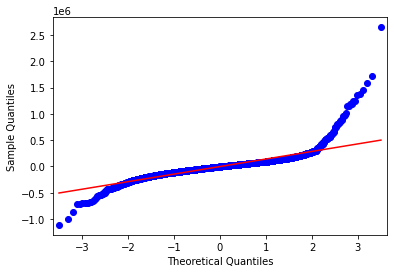

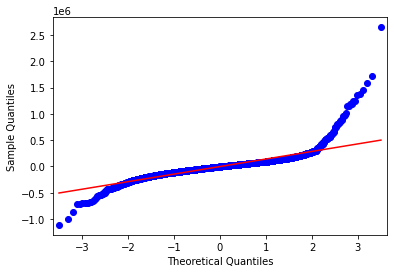

In [119]:
data = dfzip.copy()

y = data['price']
X = data.drop(['price', 'id', 'date','month','zipcode','yr_renovated',
                     'sqft_lot15','bedrooms','has_basement','sqft_living15','lat','long','num_bedrooms'], axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

len(X_test)

linreg = LinearRegression()
linreg.fit(X_train, y_train)

y_hat_train = linreg.predict(X_train)
y_hat_test = linreg.predict(X_test)


mse_train = mean_squared_error(y_train, y_hat_train)
mse_test = mean_squared_error(y_test, y_hat_test)

print('Train MSE:', mse_train)
print('Test MSE:', mse_test)

print('RMSE Train:', np.sqrt(mse_train))
print('RMSE Test:', np.sqrt(mse_test))

r2_score(y_test, y_hat_test)

residuals = (y_test - y_hat_test)

statsmodels.graphics.gofplots.qqplot(residuals, line = "r")

In [195]:
#.10 higher on R2 so thats good need to reduce zip to 4-10 sectors

## Floors as dummy vars

In [120]:
df.floors.unique()

array([1. , 2. , 1.5, 3. , 2.5, 3.5])

In [121]:
df.floors = df.floors.map(lambda x: round(x+.01))

In [127]:
floors = pd.get_dummies(df['floors'], prefix = 'floor',drop_first=True)
dffloor = pd.concat([df, floors], axis = 1)

In [132]:
outcome = 'price'
x_cols = dffloor.drop(['price', 'id', 'date','month','floors','yr_renovated','bedrooms','has_basement','yr_built','sqft_living15','sqft_lot15'], axis = 1).columns

predictors = '+'.join(x_cols)

f = outcome + '~' + predictors

In [133]:
modelfloor = ols(formula=f,data = dffloor).fit()
modelfloor.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.702
Model:                            OLS   Adj. R-squared:                  0.701
Method:                 Least Squares   F-statistic:                     2528.
Date:                Wed, 13 Jan 2021   Prob (F-statistic):               0.00
Time:                        17:39:42   Log-Likelihood:            -2.9340e+05
No. Observations:               21534   AIC:                         5.868e+05
Df Residuals:                   21513   BIC:                         5.870e+05
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept           8.557e+06   2.83e+06      3.021      0.003    3.01e+06    1.41e+07
num_bedrooms[T.2]  -4.332e+04   1.48e+04     -2.918      0.004   -7.24e+04   -1.42e+04
num_bedrooms[T.3]   -1.06e+05   1.46e+04     -7.242      0.000   -1.35e+05   -7.73e+04
num_bedrooms[T.4]  -1.499e+05   1.49e+04    -10.030      0.000   -1.79e+05   -1.21e+05
num_bedrooms[T.5+] -1.542e+05   1.57e+04     -9.809      0.000   -1.85e+05   -1.23e+05
bathrooms           4.106e+04   3222.694     12.741      0.000    3.47e+04    4.74e+04
sqft_living          190.5373      3.398     56.069      0.000     183.877     197.198
sqft_lot              -0.0775      0.035     -2.236      0.025      -0.145      -0.010
waterfront            5.9e+05   1.81e+04     32.605      0.000    5.55e+05    6.25e+05
view                5.542e+04   2087.653     26.547      0.000    5.13e+04    5.95e+04
condition           2.619e+04   2336.788     11.210      0.000    2.16e+04    3.08e+04
grade                1.03e+05   2066.561     49.839      0.000    9.89e+04    1.07e+05
sqft_basement        -38.2275      4.312     -8.866      0.000     -46.679     -29.776
zipcode             -617.3671     32.750    -18.851      0.000    -681.560    -553.174
lat                 5.905e+05   1.07e+04     55.055      0.000     5.7e+05    6.12e+05
long               -1.887e+05    1.3e+04    -14.546      0.000   -2.14e+05   -1.63e+05
been_renovated       3.79e+04   7182.534      5.276      0.000    2.38e+04     5.2e+04
age                 2653.6114     70.554     37.611      0.000    2515.320    2791.902
floor_2            -7216.5161   3622.222     -1.992      0.046   -1.43e+04    -116.691
floor_3             5.633e+04   8244.771      6.833      0.000    4.02e+04    7.25e+04
floor_4             1.574e+05   7.58e+04      2.078      0.038    8944.456    3.06e+05
==============================================================================
Omnibus:                    17571.749   Durbin-Watson:                   1.990
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1573364.052
Skew:                           3.367   Prob(JB):                         0.00
Kurtosis:                      44.330   Cond. No.                     2.07e+08
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.07e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

No material change with floor as categorical or with dummy variables so will leave as original

## Model with outliers past 3std dropped

In [134]:
df.been_renovated.value_counts()

0.0    20645
1.0      889
Name: been_renovated, dtype: int64

In [138]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21534 entries, 0 to 21596
Data columns (total 25 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   id              21534 non-null  int64         
 1   date            21534 non-null  datetime64[ns]
 2   price           21534 non-null  float64       
 3   bedrooms        21534 non-null  int64         
 4   bathrooms       21534 non-null  float64       
 5   sqft_living     21534 non-null  int64         
 6   sqft_lot        21534 non-null  int64         
 7   floors          21534 non-null  int64         
 8   waterfront      21534 non-null  float64       
 9   view            21534 non-null  float64       
 10  condition       21534 non-null  int64         
 11  grade           21534 non-null  int64         
 12  sqft_basement   21534 non-null  int64         
 13  yr_built        21534 non-null  int64         
 14  yr_renovated    17704 non-null  float64       
 15  zi

In [142]:
from scipy import stats
df_zscore = df.drop(['date','num_bedrooms','yr_renovated'], axis=1)
df_zscore = df[(np.abs(stats.zscore(df_zscore)) < 3).all(axis=1)]

In [143]:
df_zscore.been_renovated.unique()

array([0.])

In [121]:
df_zscore = df.drop(['date','yr_renovated'], axis=1)

In [124]:
df_zscore.been_renovated.std()

0.20150026671603066

In [117]:
df_zscore = df_zscore[(np.abs(stats.zscore(df_zscore)) < 3).all(axis=1)]

array([[<AxesSubplot:title={'center':'id'}>,
        <AxesSubplot:title={'center':'price'}>,
        <AxesSubplot:title={'center':'bedrooms'}>,
        <AxesSubplot:title={'center':'bathrooms'}>,
        <AxesSubplot:title={'center':'sqft_living'}>],
       [<AxesSubplot:title={'center':'sqft_lot'}>,
        <AxesSubplot:title={'center':'floors'}>,
        <AxesSubplot:title={'center':'waterfront'}>,
        <AxesSubplot:title={'center':'view'}>,
        <AxesSubplot:title={'center':'condition'}>],
       [<AxesSubplot:title={'center':'grade'}>,
        <AxesSubplot:title={'center':'sqft_basement'}>,
        <AxesSubplot:title={'center':'yr_built'}>,
        <AxesSubplot:title={'center':'yr_renovated'}>,
        <AxesSubplot:title={'center':'zipcode'}>],
       [<AxesSubplot:title={'center':'lat'}>,
        <AxesSubplot:title={'center':'long'}>,
        <AxesSubplot:title={'center':'sqft_living15'}>,
        <AxesSubplot:title={'center':'sqft_lot15'}>,
        <AxesSubplot:title={'cent

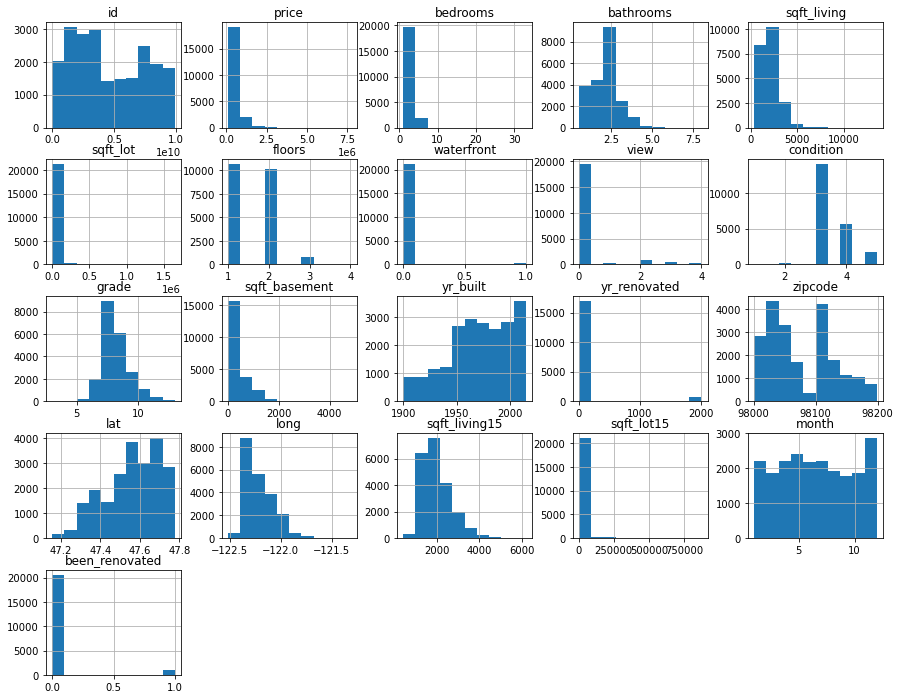

In [105]:
df.hist(figsize=(15,12))

In [118]:
len(df) -  len(df_zscore)

3097

In [86]:
#dropping outliers via zscore removes some 3k rows of data

In [87]:
df_zscore.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_basement', 'yr_built', 'been_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15', 'month'],
      dtype='object')

In [138]:
outcome = 'price'
x_cols = df_zscore.drop(['price', 'id','month','sqft_living15','sqft_lot15'], axis = 1).columns

predictors = '+'.join(x_cols)

f = outcome + '~' + predictors

In [139]:
modelz = ols(formula=f,data = df_zscore).fit()
modelz.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.689
Model:                            OLS   Adj. R-squared:                  0.689
Method:                 Least Squares   F-statistic:                     3178.
Date:                Tue, 12 Jan 2021   Prob (F-statistic):               0.00
Time:                        02:41:11   Log-Likelihood:            -2.9384e+05
No. Observations:               21534   AIC:                         5.877e+05
Df Residuals:                   21518   BIC:                         5.878e+05
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept       1.019e+07   2.91e+06      3.497      0.000    4.48e+06    1.59e+07
bedrooms       -3.746e+04   1927.067    -19.438      0.000   -4.12e+04   -3.37e+04
bathrooms       4.006e+04   3286.251     12.191      0.000    3.36e+04    4.65e+04
sqft_living      189.4562      3.399     55.747      0.000     182.795     196.118
sqft_lot          -0.0670      0.035     -1.898      0.058      -0.136       0.002
floors          7144.5380   3175.290      2.250      0.024     920.733    1.34e+04
waterfront      1.985e+05   1.06e+04     18.737      0.000    1.78e+05    2.19e+05
view            7.272e+04   2036.241     35.715      0.000    6.87e+04    7.67e+04
condition       2.578e+04   2373.337     10.863      0.000    2.11e+04    3.04e+04
grade           9.992e+04   2099.448     47.594      0.000    9.58e+04    1.04e+05
sqft_basement    -33.7739      4.329     -7.802      0.000     -42.259     -25.288
yr_built       -2624.2975     71.149    -36.885      0.000   -2763.755   -2484.840
zipcode         -616.6049     33.376    -18.475      0.000    -682.023    -551.186
lat             6.026e+05   1.09e+04     55.356      0.000    5.81e+05    6.24e+05
long           -2.136e+05   1.31e+04    -16.280      0.000   -2.39e+05   -1.88e+05
been_renovated  4.106e+04   7222.815      5.685      0.000    2.69e+04    5.52e+04
==============================================================================
Omnibus:                    18314.720   Durbin-Watson:                   1.996
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1743969.918
Skew:                           3.589   Prob(JB):                         0.00
Kurtosis:                      46.499   Cond. No.                     2.08e+08
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.08e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [90]:
dfzip2 = pd.concat([df_zscore, zipcode], axis = 1)

In [91]:
outcome = 'price'
x_cols = dfzip2.drop(['price', 'id','date','month','sqft_living15','sqft_lot15','zipcode'], axis = 1).columns

predictors = '+'.join(x_cols)

f = outcome + '~' + predictors

In [92]:
modelz = ols(formula=f,data = dfzip2).fit()
modelz.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.831
Model:                            OLS   Adj. R-squared:                  0.830
Method:                 Least Squares   F-statistic:                     1112.
Date:                Mon, 11 Jan 2021   Prob (F-statistic):               0.00
Time:                        15:11:57   Log-Likelihood:            -2.3724e+05
No. Observations:               18407   AIC:                         4.746e+05
Df Residuals:                   18325   BIC:                         4.753e+05
Df Model:                          81                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept      -1.773e+07   5.05e+06     -3.515      0.000   -2.76e+07   -7.84e+06
bedrooms       -5782.3364   1110.688     -5.206      0.000   -7959.389   -3605.284
bathrooms       1.662e+04   1813.442      9.167      0.000    1.31e+04    2.02e+04
sqft_living      145.3012      2.052     70.809      0.000     141.279     149.323
sqft_lot           0.7772      0.073     10.686      0.000       0.635       0.920
floors          -1.75e+04   1834.901     -9.536      0.000   -2.11e+04   -1.39e+04
waterfront      -3.23e-06   9.19e-07     -3.514      0.000   -5.03e-06   -1.43e-06
view             3.81e+04   1842.903     20.672      0.000    3.45e+04    4.17e+04
condition       2.321e+04   1258.704     18.438      0.000    2.07e+04    2.57e+04
grade             5.2e+04   1213.127     42.863      0.000    4.96e+04    5.44e+04
sqft_basement    -59.2228      2.552    -23.207      0.000     -64.225     -54.221
yr_built        -635.8370     41.330    -15.384      0.000    -716.847    -554.827
been_renovated -5.581e-07   1.59e-07     -3.513      0.000   -8.69e-07   -2.47e-07
lat             1.437e+05   4.29e+04      3.352      0.001    5.97e+04    2.28e+05
long            -9.95e+04   4.07e+04     -2.446      0.014   -1.79e+05   -1.98e+04
zip_98001      -4.155e+05   7.26e+04     -5.727      0.000   -5.58e+05   -2.73e+05
zip_98002      -3.962e+05   7.04e+04     -5.628      0.000   -5.34e+05   -2.58e+05
zip_98003       -4.23e+05   7.41e+04     -5.710      0.000   -5.68e+05   -2.78e+05
zip_98004       1.613e+05   7.28e+04      2.216      0.027    1.86e+04    3.04e+05
zip_98005      -1.157e+05   7.16e+04     -1.616      0.106   -2.56e+05    2.47e+04
zip_98006      -1.672e+05      7e+04     -2.390      0.017   -3.04e+05   -3.01e+04
zip_98007        -1.9e+05   7.07e+04     -2.688      0.007   -3.28e+05   -5.15e+04
zip_98008      -2.077e+05   6.96e+04     -2.986      0.003   -3.44e+05   -7.14e+04
zip_98010      -3.096e+05   6.34e+04     -4.885      0.000   -4.34e+05   -1.85e+05
zip_98011      -3.234e+05   7.48e+04     -4.324      0.000    -4.7e+05   -1.77e+05
zip_98014      -3.141e+05   6.42e+04     -4.895      0.000    -4.4e+05   -1.88e+05
zip_98019      -3.495e+05   6.65e+04     -5.260      0.000    -4.8e+05   -2.19e+05
zip_98022      -3.727e+05   6.16e+04     -6.053      0.000   -4.93e+05   -2.52e+05
zip_98023      -4.438e+05   7.61e+04     -5.831      0.000   -5.93e+05   -2.95e+05
zip_98024       -2.72e+05   6.26e+04     -4.347      0.000   -3.95e+05   -1.49e+05
zip_98027      -2.265e+05   6.59e+04     -3.438      0.001   -3.56e+05   -9.73e+04
zip_98028      -3.416e+05   7.63e+04     -4.478      0.000   -4.91e+05   -1.92e+05
zip_98029      -1.999e+05   6.47e+04     -3.087      0.002   -3.27e+05    -7.3e+04
zip_98030      -4.095e+05   6.98e+04     -5.866      0.000   -5.46e+05   -2.73e+05
zip_98031   

From our original dataframe without dropping any rows:


Mean Price of a home is $540,297

Stan Dev of a home is $367,368

## Model with log of continuous values 

In [93]:
def normalize(x):
    return(x - np.mean(x))/ (max(x) - min(x))

In [94]:
df_zscore.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_basement', 'yr_built', 'been_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15', 'month'],
      dtype='object')

In [95]:
dflog = df_zscore.drop('date',axis=1)
dflog['log_sqft_living'] = np.log(dflog['sqft_living'])


In [100]:
dflog.head()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_basement,yr_built,been_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,month,log_sqft_living,log_sqft_basement,log_sqft_lot,log_sqft_lot15,log_sqft_living15
0,7129300520,221900.0,3,1.00,1180,5650,1,0.0,0.0,3,7,0,1955,0.0,98178,47.5112,-122.257,1340,5650,10,7.073270,0.000000,8.639411,8.639411,7.200425
2,5631500400,180000.0,2,1.00,770,10000,1,0.0,0.0,3,6,0,1933,0.0,98028,47.7379,-122.233,2720,8062,2,6.646391,0.000000,9.210340,8.994917,7.908387
3,2487200875,604000.0,4,3.00,1960,5000,1,0.0,0.0,5,7,910,1965,0.0,98136,47.5208,-122.393,1360,5000,12,7.580700,6.813445,8.517193,8.517193,7.215240
4,1954400510,510000.0,3,2.00,1680,8080,1,0.0,0.0,3,8,0,1987,0.0,98074,47.6168,-122.045,1800,7503,2,7.426549,0.000000,8.997147,8.923058,7.495542
6,1321400060,257500.0,3,2.25,1715,6819,2,0.0,0.0,3,7,0,1995,0.0,98003,47.3097,-122.327,2238,6819,6,7.447168,0.000000,8.827468,8.827468,7.713338


In [99]:
dflog['log_sqft_living'] = np.log(dflog['sqft_living'])
dflog['log_sqft_lot'] = np.log(dflog['sqft_lot'])
dflog['log_sqft_lot15'] = np.log(dflog['sqft_lot15'])
dflog['log_sqft_living15'] = np.log(dflog['sqft_living15'])
dflog['log_sqft_basement'] = dflog['sqft_basement'].apply(lambda x: np.log(x) if x != 0 else x)


In [101]:
outcome = 'price'
x_cols = dflog.drop(['price', 'id','month','sqft_living15','sqft_lot15','sqft_living','sqft_basement','sqft_lot'],
                     axis = 1).columns

predictors = '+'.join(x_cols)

f = outcome + '~' + predictors

In [102]:
modellogz = ols(formula=f , data = dflog).fit()
modellogz.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.668
Model:                            OLS   Adj. R-squared:                  0.668
Method:                 Least Squares   F-statistic:                     2469.
Date:                Mon, 11 Jan 2021   Prob (F-statistic):               0.00
Time:                        15:16:08   Log-Likelihood:            -2.4345e+05
No. Observations:               18407   AIC:                         4.869e+05
Df Residuals:                   18391   BIC:                         4.871e+05
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept          -6.85e+05    2.2e+06     -0.312      0.755   -4.99e+06    3.62e+06
bedrooms          -9793.0964   1569.138     -6.241      0.000   -1.29e+04   -6717.440
bathrooms          3.225e+04   2552.184     12.636      0.000    2.72e+04    3.73e+04
floors             1.927e+04   2560.895      7.524      0.000    1.42e+04    2.43e+04
waterfront         1.773e-08   5.72e-08      0.310      0.756   -9.43e-08     1.3e-07
view               3.965e+04   2550.388     15.546      0.000    3.46e+04    4.46e+04
condition          2.643e+04   1717.082     15.395      0.000    2.31e+04    2.98e+04
grade              9.725e+04   1587.358     61.266      0.000    9.41e+04       1e+05
yr_built          -2298.6638     53.024    -43.351      0.000   -2402.596   -2194.731
been_renovated     5.039e-09   1.58e-08      0.320      0.749   -2.59e-08    3.59e-08
zipcode            -310.6523     24.143    -12.867      0.000    -357.975    -263.329
lat                5.573e+05   7718.504     72.209      0.000    5.42e+05    5.72e+05
long              -5.834e+04   1.08e+04     -5.403      0.000   -7.95e+04   -3.72e+04
log_sqft_living    1.468e+05   5917.359     24.816      0.000    1.35e+05    1.58e+05
log_sqft_basement  -644.6573    414.783     -1.554      0.120   -1457.670     168.355
log_sqft_lot      -3031.9163   3372.198     -0.899      0.369   -9641.738    3577.905
log_sqft_lot15    -1.928e+04   3631.567     -5.310      0.000   -2.64e+04   -1.22e+04
log_sqft_living15  9.807e+04   5415.940     18.107      0.000    8.75e+04    1.09e+05
==============================================================================
Omnibus:                     5339.938   Durbin-Watson:                   1.968
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            24076.419
Skew:                           1.352   Prob(JB):                         0.00
Kurtosis:                       7.907   Cond. No.                     5.07e+21
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 6.9e-30. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

Train MSE: 18152812939.53624
Test MSE: 17413922136.693714
RMSE Train: 134732.37524639815
RMSE Test: 131961.82075393517


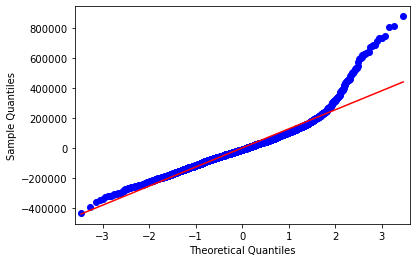

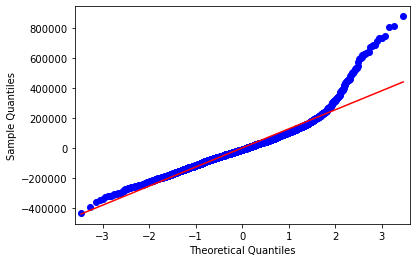

In [103]:
data = dflog.copy()

y = data['price']
X = data.drop(['price', 'id','month','sqft_living15','sqft_lot15','sqft_living','sqft_basement','sqft_lot'], axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

len(X_test)

linreg = LinearRegression()
linreg.fit(X_train, y_train)

y_hat_train = linreg.predict(X_train)
y_hat_test = linreg.predict(X_test)


mse_train = mean_squared_error(y_train, y_hat_train)
mse_test = mean_squared_error(y_test, y_hat_test)

print('Train MSE:', mse_train)
print('Test MSE:', mse_test)

print('RMSE Train:', np.sqrt(mse_train))
print('RMSE Test:', np.sqrt(mse_test))

r2_score(y_test, y_hat_test)

residuals = (y_test - y_hat_test)

statsmodels.graphics.gofplots.qqplot(residuals, line = "r")

## Model of lognorm for cont values

In [104]:
dflognorm = dflog.apply(lambda x: x*(1))

In [107]:
dflognorm.drop(['sqft_living15','sqft_lot15','sqft_living','sqft_basement','sqft_lot'],axis=1,inplace=True)

In [144]:
dflognorm['lognorm_sqft_living'] = normalize(dflognorm['log_sqft_living'])

In [137]:

dflognorm['lognorm_sqft_lot'] = normalize(dflognorm['log_sqft_lot'])
dflognorm['lognorm_sqft_lot15'] = normalize(dflognorm['log_sqft_lot15'])
dflognorm['lognorm_sqft_living15'] = normalize(dflognorm['log_sqft_living15'])
dflognorm['lognorm_sqft_basement'] = normalize(dflognorm['log_sqft_basement'])

In [138]:
dflognorm.columns

Index(['id', 'price', 'bedrooms', 'bathrooms', 'floors', 'waterfront', 'view',
       'condition', 'grade', 'yr_built', 'been_renovated', 'zipcode', 'lat',
       'long', 'month', 'log_sqft_living', 'log_sqft_basement', 'log_sqft_lot',
       'log_sqft_lot15', 'log_sqft_living15', 'lognorm_sqft_lot',
       'lognorm_sqft_lot15', 'lognorm_sqft_living15', 'lognorm_sqft_basement'],
      dtype='object')

In [145]:
outcome = 'price'
x_cols = dflognorm.drop(['price', 'id','month','log_sqft_lot','log_sqft_lot15','log_sqft_living15','log_sqft_basement','log_sqft_living'],
                     axis = 1).columns

predictors = '+'.join(x_cols)

f = outcome + '~' + predictors

In [146]:
modellognorm = ols(formula=f , data = dflognorm).fit()
modellognorm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.668
Model:                            OLS   Adj. R-squared:                  0.668
Method:                 Least Squares   F-statistic:                     2469.
Date:                Mon, 11 Jan 2021   Prob (F-statistic):               0.00
Time:                        15:42:43   Log-Likelihood:            -2.4345e+05
No. Observations:               18407   AIC:                         4.869e+05
Df Residuals:                   18391   BIC:                         4.871e+05
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept              9.541e+05   2.19e+06      0.436      0.663   -3.33e+06    5.24e+06
bedrooms              -9793.0964   1569.138     -6.241      0.000   -1.29e+04   -6717.440
bathrooms              3.225e+04   2552.184     12.636      0.000    2.72e+04    3.73e+04
floors                 1.927e+04   2560.895      7.524      0.000    1.42e+04    2.43e+04
waterfront             5.884e-08   1.35e-07      0.435      0.663   -2.06e-07    3.24e-07
view                   3.965e+04   2550.388     15.546      0.000    3.46e+04    4.46e+04
condition              2.643e+04   1717.082     15.395      0.000    2.31e+04    2.98e+04
grade                  9.725e+04   1587.358     61.266      0.000    9.41e+04       1e+05
yr_built              -2298.6638     53.024    -43.351      0.000   -2402.596   -2194.731
been_renovated        -7.684e-10   1.66e-09     -0.463      0.644   -4.02e-09    2.49e-09
zipcode                -310.6523     24.143    -12.867      0.000    -357.975    -263.329
lat                    5.573e+05   7718.504     72.209      0.000    5.42e+05    5.72e+05
long                  -5.834e+04   1.08e+04     -5.403      0.000   -7.95e+04   -3.72e+04
lognorm_sqft_lot       -1.69e+04   1.88e+04     -0.899      0.369   -5.38e+04    1.99e+04
lognorm_sqft_lot15    -9.585e+04   1.81e+04     -5.310      0.000   -1.31e+05   -6.05e+04
lognorm_sqft_living15  2.131e+05   1.18e+04     18.107      0.000     1.9e+05    2.36e+05
lognorm_sqft_basement -4756.1262   3060.167     -1.554      0.120   -1.08e+04    1242.085
lognorm_sqft_living    3.748e+05   1.51e+04     24.816      0.000    3.45e+05    4.04e+05
==============================================================================
Omnibus:                     5339.938   Durbin-Watson:                   1.968
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            24076.419
Skew:                           1.352   Prob(JB):                         0.00
Kurtosis:                       7.907   Cond. No.                     9.22e+21
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.08e-30. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

## Lognorm + zip dummies 

In [147]:
lognormzip = pd.concat([dflognorm, zipcode], axis = 1)

In [158]:
lognormzip.dropna(inplace=True)

In [159]:
outcome = 'price'
x_cols = lognormzip.drop(['price', 'id','month','log_sqft_lot','log_sqft_lot15','log_sqft_living15','log_sqft_basement','log_sqft_living','zipcode'],
                     axis = 1).columns

predictors = '+'.join(x_cols)

f = outcome + '~' + predictors

In [160]:
model8 = ols(formula=f , data = lognormzip).fit()
model8.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.819
Model:                            OLS   Adj. R-squared:                  0.818
Method:                 Least Squares   F-statistic:                     996.4
Date:                Mon, 11 Jan 2021   Prob (F-statistic):               0.00
Time:                        15:50:38   Log-Likelihood:            -2.3789e+05
No. Observations:               18407   AIC:                         4.759e+05
Df Residuals:                   18323   BIC:                         4.766e+05
Df Model:                          83                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept             -1.832e+07   5.25e+06     -3.492      0.000   -2.86e+07   -8.04e+06
bedrooms              -4864.1957   1179.879     -4.123      0.000   -7176.869   -2551.523
bathrooms               2.36e+04   1901.518     12.413      0.000    1.99e+04    2.73e+04
floors                -1154.2622   1980.329     -0.583      0.560   -5035.892    2727.368
waterfront             2.109e-06   6.04e-07      3.492      0.000    9.25e-07    3.29e-06
view                   3.557e+04   1922.962     18.498      0.000    3.18e+04    3.93e+04
condition              2.116e+04   1305.958     16.202      0.000    1.86e+04    2.37e+04
grade                  6.034e+04   1254.420     48.103      0.000    5.79e+04    6.28e+04
yr_built               -542.0145     44.801    -12.098      0.000    -629.829    -454.200
been_renovated        -9.385e-07   2.69e-07     -3.490      0.000   -1.47e-06   -4.11e-07
lat                    1.338e+05   4.44e+04      3.012      0.003    4.67e+04    2.21e+05
long                  -1.081e+05   4.23e+04     -2.559      0.010   -1.91e+05   -2.53e+04
lognorm_sqft_lot       1.948e+05   1.42e+04     13.735      0.000    1.67e+05    2.23e+05
lognorm_sqft_lot15    -2.705e+04   1.37e+04     -1.970      0.049    -5.4e+04    -131.334
lognorm_sqft_living15  1.076e+05   9039.361     11.908      0.000    8.99e+04    1.25e+05
lognorm_sqft_basement -3.543e+04   2341.515    -15.129      0.000      -4e+04   -3.08e+04
lognorm_sqft_living      4.7e+05   1.13e+04     41.427      0.000    4.48e+05    4.92e+05
zip_98001              -4.37e+05   7.55e+04     -5.788      0.000   -5.85e+05   -2.89e+05
zip_98002             -3.985e+05   7.32e+04     -5.445      0.000   -5.42e+05   -2.55e+05
zip_98003             -4.453e+05   7.71e+04     -5.777      0.000   -5.96e+05   -2.94e+05
zip_98004              1.425e+05   7.57e+04      1.883      0.060   -5836.020    2.91e+05
zip_98005             -1.349e+05   7.45e+04     -1.812      0.070   -2.81e+05     1.1e+04
zip_98006             -1.841e+05   7.28e+04     -2.529      0.011   -3.27e+05   -4.14e+04
zip_98007             -2.081e+05   7.35e+04     -2.831      0.005   -3.52e+05    -6.4e+04
zip_98008             -2.218e+05   7.23e+04     -3.066      0.002   -3.64e+05      -8e+04
zip_98010             -3.233e+05    6.6e+04     -4.897      0.000   -4.53e+05   -1.94e+05
zip_98011             -3.406e+05   7.78e+04     -4.378      0.000   -4.93e+05   -1.88e+05
zip_98014             -3.278e+05   6.68e+04     -4.905      0.000   -4.59e+05   -1.97e+05
zip_98019             -3.676e+05   6.91e+04     -5.316      0.000   -5.03e+05   -2.32e+05
zip_98022             -3.884e+05   6.41e+04     -6.061      0.000   -5.14e+05   -2.63e+05
zip_98023             -4.636e+05   7.92e+04     -5.855      0.000   -6.19e+05   -3.08e+05
zip_98024             -

Train MSE: 9852455954.933586
Test MSE: 9825101683.23399
RMSE Train: 99259.53835744747
RMSE Test: 99121.65093073253


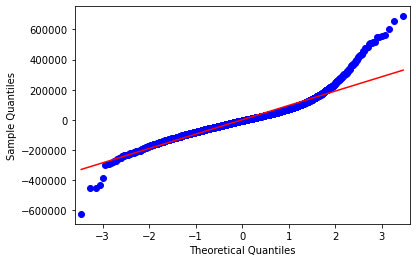

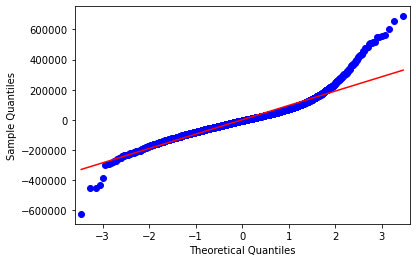

In [164]:
data = lognormzip.copy()

y = data['price']
X = data.drop(['price', 'id','month','log_sqft_lot','log_sqft_lot15','log_sqft_living15','log_sqft_basement','log_sqft_living','zipcode'], axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

len(X_test)

linreg = LinearRegression()
linreg.fit(X_train, y_train)

y_hat_train = linreg.predict(X_train)
y_hat_test = linreg.predict(X_test)


mse_train = mean_squared_error(y_train, y_hat_train)
mse_test = mean_squared_error(y_test, y_hat_test)

print('Train MSE:', mse_train)
print('Test MSE:', mse_test)

print('RMSE Train:', np.sqrt(mse_train))
print('RMSE Test:', np.sqrt(mse_test))

r2_score(y_test, y_hat_test)

residuals = (y_test - y_hat_test)

statsmodels.graphics.gofplots.qqplot(residuals, line = "r")

In [1]:
plt.figure(figsize=(8,10))
sns.scatterplot(x='long', y='lat', hue = 'zipcode', data=df, palette='Paired')

NameError: name 'plt' is not defined

For Waterfront homes:

Average price of a home is 1,717,215

Std Dev of a house is 1,145,384



In [90]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21534 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   id             21534 non-null  int64         
 1   date           21534 non-null  datetime64[ns]
 2   price          21534 non-null  float64       
 3   bedrooms       21534 non-null  int64         
 4   bathrooms      21534 non-null  float64       
 5   sqft_living    21534 non-null  int64         
 6   sqft_lot       21534 non-null  int64         
 7   floors         21534 non-null  float64       
 8   waterfront     21534 non-null  float64       
 9   view           21534 non-null  float64       
 10  condition      21534 non-null  int64         
 11  grade          21534 non-null  int64         
 12  sqft_basement  21534 non-null  int64         
 13  yr_built       21534 non-null  int64         
 14  yr_renovated   21534 non-null  float64       
 15  zipcode        2153

## Model With Z-Score outliers dropped

In [92]:
df_zscore.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21534 entries, 0 to 21596
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21534 non-null  int64  
 1   price          21534 non-null  float64
 2   bedrooms       21534 non-null  int64  
 3   bathrooms      21534 non-null  float64
 4   sqft_living    21534 non-null  int64  
 5   sqft_lot       21534 non-null  int64  
 6   floors         21534 non-null  float64
 7   waterfront     21534 non-null  float64
 8   view           21534 non-null  float64
 9   condition      21534 non-null  int64  
 10  grade          21534 non-null  int64  
 11  sqft_basement  21534 non-null  int64  
 12  yr_built       21534 non-null  int64  
 13  yr_renovated   21534 non-null  float64
 14  zipcode        21534 non-null  int64  
 15  lat            21534 non-null  float64
 16  long           21534 non-null  float64
 17  sqft_living15  21534 non-null  int64  
 18  sqft_l

In [ ]:
#group months into seasons or quarters to run together
#could look into when in the month 
np

In [ ]:
#repeat distribution for waterfront variable as well with random choice 

In [94]:
locations = nawater[['lat', 'long']]
locationlist = locations.values.tolist()
locations


,lat,long
0,47.5112,-122.257
10,47.6007,-122.145
23,47.3533,-122.166
40,47.6145,-122.027
55,47.6597,-122.290
...,...,...
21578,47.3749,-122.107
21582,47.2931,-122.264
21586,47.3095,-122.002
21587,47.5389,-121.881


In [95]:
locations.mean()

lat      47.561465
long   -122.213497
dtype: float64

#waterfront`

In [102]:
map = folium.Map(location=[47.5614, -122.257], zoom_start=12)
for point in range(0, len(locationlist)):
    folium.Marker(locationlist[point], popup=nawater['id']).add_to(map)
map
dff


NameError: name 'dff' is not defined

In [43]:
df.id.duplicated().sum()

177

In [40]:
resold = df[df.id.duplicated(keep=False)].sort_values('id')

In [ ]:
resold

In [98]:
import plotly.express as px

In [ ]:
px.bar(df, x)